In [1]:
import os
import pandas as pd
import numpy as np
import pyupbit
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import TimeSeriesSplit
from lightgbm import LGBMClassifier

import feature
import evaluation

In [2]:
pd.set_option("display.max_columns", None)
np.set_printoptions(precision=3)

In [3]:
filename = "krw_eth_upbit.csv"
if os.path.isfile(filename):
    df = pd.read_csv(filename, index_col = "datetime")
    df.sort_index(inplace=True)
else:
    df = pyupbit.get_ohlcv("KRW-ETH", interval="minute1", count=212400)
    df.rename_axis("datetime", inplace=True)
    df.sort_index(inplace=True)
    df.to_csv(filename)

### Hyper-parameters & variables

In [4]:
moving_windows = [5, 20, 60, 120, 200]
stochastic_fast_windows = [5, 10, 20]
stochastic_slow_windows = [3, 6, 12]
target_window = 120
target_earning_rate = 0.03
fee = 0.0005 # trade fee
train_start_date = "2021-01-01 00:00:00"
test_start_date = "2021-12-01 00:00:01"

### Generate Features

In [5]:
# Moving Average
for mw in moving_windows:
    df["ma{}".format(mw)], df["ms{}".format(mw)], df["upper{}".format(mw)], df["lower{}".format(mw)] = feature.moving_average(df["close"], mw)
for fst, scd in zip(moving_windows[:-1], moving_windows[1:]):
    df["ma{}-ma{}".format(scd, fst)] = df["ma{}".format(scd)] = df["ma{}".format(fst)]
# Volume Average
df["va"], df["vva"] = feature.volume_average(df["volume"], 120)
# MACD
df["macd_short"], df["macd_long"], df["macd_signal"], df["macd"], df["macd_oscil"] = feature.moving_average_convergence_divergence(df["close"])
# Stochastic Fast/Slow
for fv, sv in zip(stochastic_fast_windows, stochastic_slow_windows):
    df["fastk{}".format(fv)] = feature.get_stochastic_fast_k(df["close"], df["low"], df["high"], fv)
    df["slowk{}".format(sv)] = feature.get_stochastic_slow_k(df["fastk{}".format(fv)], sv)
    df["slowd{}".format(sv)] = feature.get_stochastic_slow_d(df["slowk{}".format(sv)], sv)
# RSI
df["rsi"] = feature.get_rsi(df["close"])

### Make Labels

In [6]:
df["buy"] = df["close"].shift(-1) # Buy after 1 minute
df["sell_last"] = df["close"].shift(-1-target_window) # price after target window
indexer = pd.api.indexers.FixedForwardWindowIndexer(window_size=target_window)
df["sell_max"] = df["close"].shift(-2).rolling(window=indexer).max() # max price in target window

df["earn_last"] = df["sell_last"] / df["buy"] - 1
df["earn_max"] = df["sell_max"] / df["buy"] - 1

df["target"] = (df["earn_max"] >= target_earning_rate).astype(int)

In [7]:
df.dropna(inplace=True)

### Train Models

In [8]:
selected_features = ['volume', 'va', 'vva', 'rsi',
                     'ma5', 'ms5', 'upper5', 'lower5', 
                     'ma20', 'ms20', 'upper20', 'lower20', 
                     'ma60', 'ms60', 'upper60', 'lower60', 
                     'ma120', 'ms120', 'upper120', 'lower120',
                     'ma200', 'ms200', 'upper200', 'lower200', 
                     'ma20-ma5', 'ma60-ma20', 'ma120-ma60', 'ma200-ma120',
                     'macd_short', 'macd_long', 'macd_signal', 'macd', 'macd_oscil', 
                     'fastk5', 'slowk3', 'slowd3', 'fastk10', 'slowk6','slowd6', 'fastk20', 'slowk12', 'slowd12' 
                    ]

In [9]:
df_train = df[train_start_date:test_start_date]
df_test = df[test_start_date:]
df_eval = df_test[["buy", "sell_last", "sell_max", "earn_last", "earn_max", "target"]].copy()

In [10]:
X_train, y_train = df_train[selected_features], df_train["target"]
X_test, y_test = df_test[selected_features], df_test["target"]

#### randomforeset

In [11]:
rf = RandomForestClassifier(n_estimators=100, oob_score=True, random_state=123456, n_jobs=-1)
rf.fit(X_train.values, y_train)

RandomForestClassifier(n_jobs=-1, oob_score=True, random_state=123456)

- Target Earning Rate per Transaction: 0.030
- God's Average Earning Ratio: 0.04456
- Our Model's Average Earning Ratio: 0.02218
- Our Model's Actual Buy Average Earning Ratio: 0.01374, 4
- Negative Transactions: 0, 
  []
- Precions 0.655, Recall: 0.026, F1Score: 0.049
- Confustion Matrix


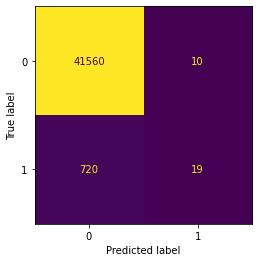

In [12]:
df_eval["predict"] = rf.predict(X_test.values)
df_eval["actual_buy"] = evaluation.get_actual_buy_time(df_eval, target_window, target_earning_rate)
evaluation.show_evaluations(df_eval, target_earning_rate)

#### lightgbm

In [19]:
lgb = LGBMClassifier(n_estimators=1000, num_leaves=64, learning_rate=0.1, 
                     max_depth=0, min_child_samples=20, bagging_freq=0, 
                     is_unbalance=True, verbose=1,
                     bagging_fraction=0.9, n_jobs=-1)
lgb.fit(X_train, y_train)

[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Info] Number of positive: 3118, number of negative: 166653
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.059633 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10707
[LightGBM] [Info] Number of data points in the train set: 169771, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.018366 -> initscore=-3.978722
[LightGBM] [Info] Start training from score -3.978722
[LightGBM] [Warning] No further splits with positiv

LGBMClassifier(bagging_fraction=0.9, bagging_freq=0, is_unbalance=True,
               max_depth=0, n_estimators=1000, num_leaves=64, verbose=1)

- Target Earning Rate per Transaction: 0.030
- God's Average Earning Ratio: 0.04456
- Our Model's Average Earning Ratio: 0.02254
- Our Model's Actual Buy Average Earning Ratio: 0.01519, 6
- Negative Transactions: 0, 
  []
- Precions 0.568, Recall: 0.028, F1Score: 0.054
- Confustion Matrix


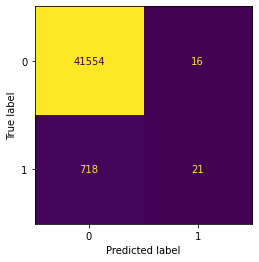

In [14]:
df_eval["predict"] = lgb.predict(X_test)
df_eval["actual_buy"] = evaluation.get_actual_buy_time(df_eval, target_window, target_earning_rate)
evaluation.show_evaluations(df_eval, target_earning_rate)

- Target Earning Rate per Transaction: 0.030
- God's Average Earning Ratio: 0.04456
- Our Model's Average Earning Ratio: 0.01690
- Our Model's Actual Buy Average Earning Ratio: 0.00951, 10
- Negative Transactions: 1, 
  [-0.019]
- Precions 0.411, Recall: 0.050, F1Score: 0.089
- Confustion Matrix


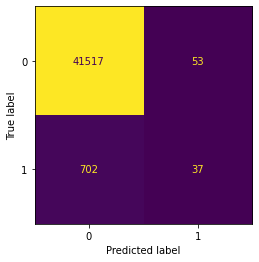

In [17]:
df_eval["predict"] = lgb.predict(X_test)
df_eval["actual_buy"] = evaluation.get_actual_buy_time(df_eval, target_window, target_earning_rate)
evaluation.show_evaluations(df_eval, target_earning_rate)

### CV 

In [34]:
def cv(model, train_X, train_y):
    tscv = TimeSeriesSplit(n_splits=10)
    f1_list = []
    model_name = model.__class__.__name__
    for _, (train_index, test_index) in tqdm(enumerate(tscv.split(train_X), start=1), desc=f'{model_name} Cross Validations...', total=10):
        X_train, X_test = train_X.iloc[train_index], train_X.iloc[test_index]
        y_train, y_test = train_y.iloc[train_index], train_y.iloc[test_index]
        clf = model.fit(X_train.values, y_train)
        pred = clf.predict(X_test.values)
        precision, recall, f1score = evaluation.get_binary_metircs(y_test, pred)
        f1_list.append(f1score)
    
    return model_name, f1_list
    

In [35]:
def print_f1_score(model, train_X, train_y):
    model_name, score = cv(model, train_X, train_y)
    for i, r in enumerate(score, start=1):
        print(f'{i} FOLDS: {model_name} F1Score: {r:.4f}')
    print(f'\n{model_name} mean RMSLE: {np.mean(score):.4f}')
    print('='*40)
    
    return model_name, np.mean(score)

In [ ]:
rf = RandomForestClassifier(n_estimators=100, oob_score=True, random_state=123456, n_jobs=-1)
lgb = LGBMClassifier(n_estimators=1000, num_leaves=64, learning_rate=0.1, 
                     max_depth=0, min_child_samples=20, bagging_freq=0, 
                     is_unbalance=True, verbose=1,
                     bagging_fraction=0.9, n_jobs=-1)
models = []
scores = []
for model in [rf, lgb]:
    model_name, mean_score = print_f1_score(model, df[selected_features], df["target"])
    models.append(model_name)
    scores.append(mean_score)

RandomForestClassifier Cross Validations...:  10%|███▌                               | 1/10 [00:03<00:34,  3.84s/it]C:\Users\meet2\miniconda3\envs\coin\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
RandomForestClassifier Cross Validations...:  60%|█████████████████████              | 6/10 [02:37<02:34, 38.60s/it]C:\Users\meet2\miniconda3\envs\coin\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
RandomForestClassifier Cross Validations...:  70%|████████████████████████▌          | 7/10 [03:38<02:18, 46.19s/it]C:\Users\meet2\m

1 FOLDS: RandomForestClassifier F1Score: 0.0000
2 FOLDS: RandomForestClassifier F1Score: 0.0000
3 FOLDS: RandomForestClassifier F1Score: 0.0177
4 FOLDS: RandomForestClassifier F1Score: 0.0000
5 FOLDS: RandomForestClassifier F1Score: 0.0000
6 FOLDS: RandomForestClassifier F1Score: 0.0000
7 FOLDS: RandomForestClassifier F1Score: 0.0000
8 FOLDS: RandomForestClassifier F1Score: 0.0000
9 FOLDS: RandomForestClassifier F1Score: 0.0642
10 FOLDS: RandomForestClassifier F1Score: 0.0000

RandomForestClassifier mean RMSLE: 0.0082


LGBMClassifier Cross Validations...:   0%|                                                   | 0/10 [00:00<?, ?it/s]

[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Info] Number of positive: 623, number of negative: 18657
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.059548 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10673
[LightGBM] [Info] Number of data points in the train set: 19280, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.032313 -> initscore=-3.399430
[LightGBM] [Info] Start training from score -3.399430
[LightGBM] [Warning] No further splits with positive g

Exception ignored on calling ctypes callback function: <function _log_callback at 0x000001362E4E9430>
Traceback (most recent call last):
  File "C:\Users\meet2\miniconda3\envs\coin\lib\site-packages\lightgbm\basic.py", line 91, in _log_callback
    def _log_callback(msg: bytes) -> None:
KeyboardInterrupt: 


No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

LGBMClassifier Cross Validations...:  10%|████▎                                      | 1/10 [00:44<06:43, 44.82s/it]

[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Info] Number of positive: 758, number of negative: 37802
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.047644 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10665
[LightGBM] [Info] Number of data points in the train set: 38560, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.019658 -> initscore=-3.909434
[LightGBM] [Info] Start training from score -3.909434
[LightGBM] [Warning] No further splits with positive g

Exception ignored on calling ctypes callback function: <function _log_callback at 0x000001362E4E9430>
Traceback (most recent call last):
  File "C:\Users\meet2\miniconda3\envs\coin\lib\site-packages\lightgbm\basic.py", line 91, in _log_callback
    def _log_callback(msg: bytes) -> None:
KeyboardInterrupt: 


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

C:\Users\meet2\miniconda3\envs\coin\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
LGBMClassifier Cross Validations...:  20%|████████▌                                  | 2/10 [01:14<04:46, 35.82s/it]

[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Info] Number of positive: 1555, number of negative: 56285
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019431 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10687
[LightGBM] [Info] Number of data points in the train set: 57840, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.026885 -> initscore=-3.588953
[LightGBM] [Info] Start training from score -3.588953
[LightGBM] [Warning] No further splits with positive 